# <center> A Quantum distance-based classifier </center>#
## <center> Robert Wezeman, TNO </center> ##

<a name="contents"></a>
# Table of Contents
* [Introduction](#introduction)
* [Problem](#problem)
* [Theory](#theory)
* [Algorithm for the arbitrary state preparation](#algorithm)
* [Implementation of the distance-based classifier](#implementation)
* [Conclusion and further work](#conclusion)

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle} $$

In [1]:
## Import external python file
import nbimporter
from data_plotter import get_bin, DataPlotter  # for easier plotting
DataPlotter = DataPlotter()

# Import math functions 
import numpy as np
from math import acos, pi, atan, sqrt
from numpy import sign

# Import plotting tools
import matplotlib.pyplot as plt

<a name="introduction"></a>
# Introduction #


This notebook is the third in the series on the quantum distance-based classifier. In the first notebook, we looked at how to build a distance-based classifier with two data points, each having two features. In the second notebook, we looked at how to increase the amount of data points. In this notebook we will look at how to increase the amount of features. 



[Back to Table of Contents](#contents)

<a name="problem"></a>
# Problem #
We repeat the problem description from the previous notebooks. We define the following binary classification problem: Given the data set 
$$\mathcal{D} = \Big\{ ({\bf x}_1, y_1), \ldots ({\bf x}_M , y_M)  \Big\},$$
consisting of $M$ data points $x_i\in\mathbb{R}^n$ and corresponding labels $y_i\in \{-1, 1\}$, give a prediction for the label $\tilde{y}$ corresponding to an unlabeled data point $\bf\tilde{x}$. The classifier we shall implement with our quantum circuit is a distance-based classifier and is given by
\begin{equation}\newcommand{\sgn}{{\rm sgn}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\label{eq:classifier} \tilde{y} = \sgn\left(\sum_{m=0}^{M-1} y_m \left[1-\frac{1}{4M}\abs{{\bf\tilde{x}}-{\bf x}_m}^2\right]\right). \hspace{3cm} (1)\end{equation}

This is a typical $M$-nearest-neighbor model where each data point is given a weight related to the distance measure. To implement this classifier on a quantum computer we use amplitude encoding. Details are found in the previous notebooks.

[Back to Contents](#contents)

<a name="theory"></a>
# Theory #

In the previous notebooks we encoded the data, each having two features, with a simple $R_y(\theta)$ rotation. The angle for this rotation was chosen such that it rotated the state $\ket{0}$ to the desired state $\ket{\bf{x}}$ corresponding to the data. If we want to include more features for our data points we need to generalize this rotation. Instead of a simple rotation, we now need a combination of gates such that it maps $\ket{0\ldots 0} \mapsto \ket{\bf x} = \sum_i a_i \ket{i}$, where $\ket{i}$ is the $i^{th}$ entry of the computational basis $\left\{\ket{0\ldots0},\ldots,\ket{1\ldots1}\right\}$. Again we only work with normalised data, meaning $\sum_i \lvert a_i \rvert^2=1$. The general procedure how to initialize a state to an arbitrary superposed state can be found in the article by [Long and Sun](https://arxiv.org/abs/quant-ph/0104030). In this notebook we will consider how to implement their scheme for 2 qubits, that is up to 4 features:
\begin{equation}
\ket{00} \mapsto a_{00} \ket{00} + a_{01} \ket{01} + a_{10} \ket{10} + a_{11} \ket{11}
\end{equation}

For the implementation we closely follow the reference and use single bit rotation gates $U(\theta)$ defined by 
\begin{equation}
U(\theta) = \begin{pmatrix} 
\cos(\theta) & \sin(\theta) \\
\sin(\theta) & -\cos(\theta) 
\end{pmatrix}  = R_y(2\theta) \cdot Z
\end{equation}
and controlled versions of it. Because we will only act with these gates on $\ket{0}$ we can even drop the $Z$ gate.

For two qubits the scheme consists of three steps:
1. Apply a bit rotation $U(\alpha_1)$ on the first qubit:
\begin{equation}
U(\alpha_1)\ket{0}\otimes\ket{0}= \sqrt{\abs{a_{00}}^2 + \abs{a_{01}}^2} \ket{00} + \sqrt{\abs{a_{10}}^2 + \abs{a_{11}}^2} \ket{10},
\end{equation}
where $\alpha_1$ is given by
\begin{equation}
\alpha_1 = \arctan\left(\sqrt{\frac{\abs{a_{10}}^2 + \abs{a_{11}}^2}{\abs{a_{00}}^2 + \abs{a_{01}}^2}}\right)
\end{equation}
2. Next, apply a controlled-rotation $U(\alpha_2)$ on the second qubit, with as control the first qubit being 0. Choose $\alpha_2$ such that:
\begin{equation}
\cos(\alpha_2) = \frac{a_{00}}{\sqrt{\abs{a_{00}}^2+\abs{a_{01}}^2}}, \hspace{1cm} \sin(\alpha_2) = \frac{a_{01}}{\sqrt{\abs{a_{00}}^2+\abs{a_{01}}^2}}
\end{equation}
3. Lastly, apply a controlled-rotation $U(\alpha_3)$ on the second qubit, with the first qubit being 1 as control. Choose $\alpha_3$ such that:
\begin{equation}
\cos(\alpha_3) = \frac{a_{10}}{\sqrt{\abs{a_{10}}^2+\abs{a_{11}}^2}}, \hspace{1cm} \sin(\alpha_3) = \frac{a_{11}}{\sqrt{\abs{a_{10}}^2+\abs{a_{11}}^2}}
\end{equation}

The angles $\alpha_2$ and $\alpha_3$ are chosen such that the root terms cancel out, leaving us with the desired result:
\begin{equation}
\begin{split}
\sqrt{\abs{a_{00}}^2 + \abs{a_{01}}^2}& \ket{0}\otimes U(\alpha_2)\ket{0} + \sqrt{\abs{a_{10}}^2 + \abs{a_{11}}^2} \ket{1}\otimes U(\alpha_3)\ket{0}\\
&=a_{11} \ket{00} + a_{01} \ket{01} + a_{10} \ket{10} + a_{11} \ket{11}
\end{split}
\end{equation}

Note: this circuit makes it also possible to encode 3 features by simply setting $a_{11}=0$. 

The circuit looks something like this:

<img src="images/images4features/rotations.png">

[Back to Table of Contents](#contents)

<a name="algorithm"></a>
# Algorithm for the arbitrary state preparation#

In this notebook we will work with the Qiskit backend for the quantum inspire. Let us first take a closer look at the state preparation part of the circuit used to preparing an arbitrary state. The following code loads the scaled and normalised data of the Iris set containing all 4 features. Let us consider the first point in this set

In [2]:
# Load scaled and normalised data
iris_setosa_normalised, iris_versicolor_normalised = DataPlotter.load_data(max_features=4)
first_data_point = [feature[0] for feature in iris_setosa_normalised]
first_data_point

[-0.32695550305984783,
 0.4736868636179572,
 -0.5699845991812187,
 -0.5863773622428564]

We want to build the circuit such that:
\begin{equation}\ket{00} \mapsto -0.3270 \ket{00} + 0.4737 \ket{01} - 0.5700 \ket{10} - 0.5864 \ket{11}\end{equation}

In [3]:
a00, a01, a10, a11 = first_data_point
alpha1 = atan(sqrt((a10**2  + a11**2) / (a00**2  + a01**2)))
alpha2 = np.arctan2(a01, a00) 
alpha3 = np.arctan2(a11, a10) 

As always the first step is to set up a connection with the Quantum Inspire:

In [4]:
import os
from getpass import getpass
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication

from qiskit.validation.base import Obj
from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_state, plot_histogram, circuit_drawer
from qiskit import execute

from quantuminspire.qiskit import QI
from quantuminspire.api import QuantumInspireAPI

QI_EMAIL = os.getenv('QI_EMAIL')
QI_PASSWORD = os.getenv('QI_PASSWORD')
QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')


def get_authentication():
    """ Gets the authentication for connecting to the Quantum Inspire API."""
    token = load_account()
    if token is not None:
        return get_token_authentication(token)
    else:
        if QI_EMAIL is None or QI_PASSWORD is None:
            print('Enter email:')
            email = input()
            print('Enter password')
            password = getpass()
        else:
            email, password = QI_EMAIL, QI_PASSWORD
        return get_basic_authentication(email, password)

    
authentication = get_authentication()
# Temporairy alternative so that we can give our project a name:
QI._api = QuantumInspireAPI(QI_URL, authentication, project_name="Distance-based Classifier more features (NEW)")

# Alternative:
# authentication = [email, password]
# QI.set_authentication_details(*authentication)

qi_backend = QI.get_backend('QX single-node simulator')

We can now construct a function which builds the quantum circuit as discussed above. Note that Qiskit contains the general unitary gates $u3(\theta, \phi, \lambda)$ which are related to our definition of $U(\alpha)$ by:$$U(\alpha) = u3(2\alpha, 0, \pi).$$
Unfortunately, these $u3$ gates are not yet implemented on the quantum inspire backend and thus we need to make use of regular $R_y$ rotations and CNOT gates.

In [5]:
def cRy(q, angle, ctrlidx, idx):
    if len(q)<2:
        raise ValueError("Error, len quantum register must at least be 2.")
    circuit = QuantumCircuit(q)
    half_angle = angle / 2
    
    circuit.cx(q[ctrlidx], q[idx])
    circuit.ry(-half_angle, q[idx])
    circuit.cx(q[ctrlidx], q[idx])
    circuit.ry(half_angle, q[idx])
    return circuit


def features_encoding(q, alpha, idx1, idx2):
    if len(q)<2:
        raise ValueError("Error, len quantum register must at least be 2.")
    # Alternative use u3(2 * alpha, 0, pi) and cu3(2 * alpha, 0, pi) gates but not yet implemented on Quantum inspire
    alpha1, alpha2, alpha3 = alpha
    
    circuit = QuantumCircuit(q)
    
    # step 1.
    circuit.ry(2 * alpha1, q[idx1])

    # # step 2.
    circuit.x(q[idx1])
    circuit = circuit + cRy(q, 2 * alpha2, idx1, idx2)
    circuit.x(q[idx1])

    # step 3.
    circuit = circuit + cRy(q, 2 * alpha3, idx1, idx2)
    return circuit


def measurement(q):
    # TO DO: Rewrite as loop over b to avoid measurement of ancillary qubits
    circuit_size = len(q)
    b = ClassicalRegister(circuit_size)
    meas = QuantumCircuit(q, b)
    meas.measure(q, b)
    return meas

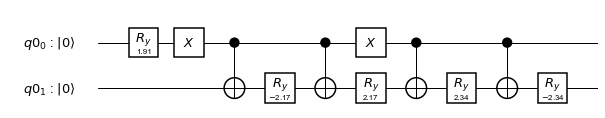

In [6]:
q = QuantumRegister(2)
circuit = features_encoding(q, [alpha1, alpha2, alpha3], 0, 1)
circuit.draw(output='mpl')

In [7]:
#Initialize quantum register:
q = QuantumRegister(2)
meas = measurement(q)

# Build circuit:
circuit = features_encoding(q, [alpha1, alpha2, alpha3], 0, 1)
qc = circuit + meas


# Execute the circuit:
def execute_circuit(circuit, shots=1):
    qi_job = execute(qc, backend=qi_backend, shots=shots)

    # Temporary needed to fix naming the project:
    project = next((project for project in QI._api.get_projects()
                    if project['name'] == QI._api.project_name), None)
    if project is not None:
        qi_job._job_id = str(project['id'])

    # Results of the job:
    qi_result = qi_job.result()

    # Select the results of the circuit and print results in a dict
    probabilities = qi_result.data(qc)['probabilities'].to_dict()
    return probabilities


def create_histogram_results(probabilities, number_of_bits=2):
    histogram_results = {}
    for k, v in probabilities.items():
        # Reversed order of the bin strings to be consistent
        histogram_results[get_bin(int(k, 16), number_of_bits)[::-1]] = v
    return histogram_results


# Display results:
probabilities = execute_circuit(qc)
create_histogram_results(probabilities)

{'00': 0.1069, '10': 0.3248822, '11': 0.3438386, '01': 0.2243793}

We can compare these results with what we expected if we measure the state $\psi = a_{00} \ket{00} + a_{01} \ket{01} + a_{10} \ket{10} + a_{11} \ket{11}$ and obtain the result $X$

| Outcome $x$ | $Prob(X=x)$ |
|-------------|----------------------|
| $\ket{00}$  | $\abs{a_{00}}^2$     |
| $\ket{01}$  | $\abs{a_{01}}^2$     |
| $\ket{10}$  | $\abs{a_{10}}^2$     |
| $\ket{11}$  | $\abs{a_{11}}^2$     |

Desired values:  [0.10689990098111816, 0.2243792447642172, 0.3248824433037745, 0.34383841095089007]


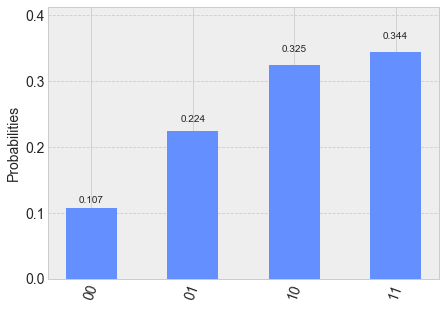

In [8]:
# Desired outcomes for the test point:
desired_outcomes = [coefficient**2 for coefficient in [a00, a01, a10, a11]]
print('Desired values: ', desired_outcomes)
plot_histogram(create_histogram_results(probabilities))

In the next section we use this feature encoding schema in the distance-based classifier for 2 data points, each having 4 features. In the algorithm however, feature encoding is done in a controlled fashion, with the index qubit as control. Therefore we will also need the same circuit as above but transformed to a controlled version. This can be done by replacing every gate by a controlled equivalent. 

In [9]:
def ccRy(q, angle, ctrlidx1, ctrlidx2, idx):
    if len(q)<3:
        raise ValueError("Error, len quantum register must at least be 3.")
    circuit = QuantumCircuit(q)
    quarter_angle = angle / 4
    
    circuit.ccx(q[ctrlidx1], q[ctrlidx2], q[idx])
    circuit.cx(q[ctrlidx2], q[idx])
    circuit.ry(quarter_angle, q[idx])
    circuit.cx(q[ctrlidx2], q[idx])
    circuit.ry(- quarter_angle, q[idx])
    
    circuit.ccx(q[ctrlidx1], q[ctrlidx2], q[idx])
    circuit.cx(q[ctrlidx2], q[idx])
    circuit.ry(-quarter_angle, q[idx])
    circuit.cx(q[ctrlidx2], q[idx])
    circuit.ry(quarter_angle, q[idx])    
    return circuit


def c_features_encoding(q, alpha, ctrlidx, idx1, idx2):
    if len(q)<3:
        raise ValueError("Error, len quantum register must at least be 3.")
    alpha1, alpha2, alpha3 = alpha
    circuit = QuantumCircuit(q)
    
    # step 1.
    circuit = circuit + cRy(q, 2 * alpha1, ctrlidx, idx1)  # old: ry(2 * alpha1, q[idx1])

    # # step 2.
    circuit.cx(q[ctrlidx], q[idx1])  # old: x(q[idx1])
    circuit = circuit + ccRy(q, 2 * alpha2, idx1, ctrlidx, idx2)  # old: cRy gates
    circuit.cx(q[ctrlidx], q[idx1])  # old: x(q[idx1])

    # step 3.
    circuit = circuit + ccRy(q, 2* alpha3, idx1, ctrlidx, idx2)  # old: cRy gates
    return circuit

[Back to Table of Contents](#contents)

<a name="implementation"></a>
# Implementation of the distance-based classifier#


We first consider the case with 2 data points and just 2 features, randomly chosen from the Iris data set. This so that we can later compare the results of the distance-based classifier with 2 features to the implementation with 4 features.

In [10]:
def two_features_classifier(q, x_tilde, x0, x1):
    if len(q) != 4:
        raise ValueError("Error, len quantum register must be 4.")
    circuit = QuantumCircuit(q)
    
    # Angles data points:
    angle_x_tilde = 2 * acos(x_tilde[0]) * sign(x_tilde[1]) # Label ?
    angle_x0 = 2 * acos(x0[0]) * sign(x0[1])                # Label 0
    angle_x1 = 2 * acos(x1[0]) * sign(x1[1])                # Label 1
 
    # part_a:
    for i in range(2):
        circuit.h(q[i])

    # part_b:
    circuit = circuit + cRy(q, angle_x_tilde, 1, 2)
    circuit.x(q[1])

    # part_c:
    circuit = circuit + ccRy(q, angle_x0, 1, 0, 2)
    circuit.x(q[0])

    # part_d:
    circuit = circuit + ccRy(q, angle_x1, 1, 0, 2)

    # part_e:
    circuit.cx(q[0], q[3])

    # part_f:
    circuit.h(q[1]);
    return circuit

The above algorithm is the same implementation of the algorithm as we did in the first notebook. The following code runs the algorithm on randomly selected data from the iris set.

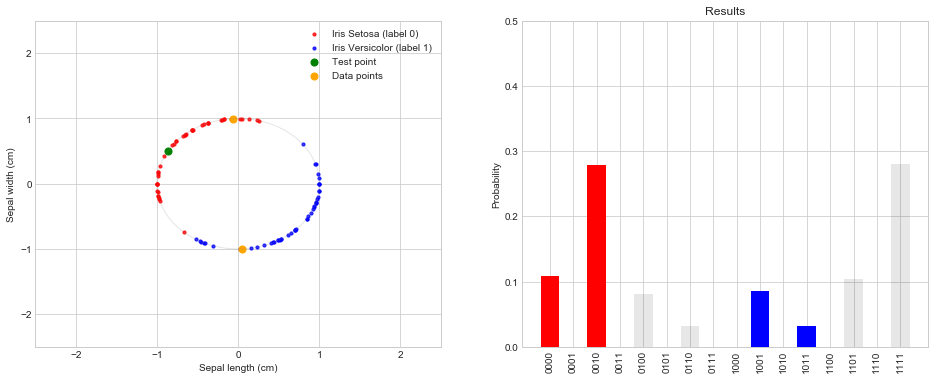

In [11]:
# Get 2 random data points with 2 features.
data_label0, data_label1, x_tilde, random_label = DataPlotter.grab_random_data(size=2, features=2)

#Initialize quantum register:
q = QuantumRegister(4)
meas = measurement(q)

# Initialize circuit:
circuit = two_features_classifier(q, x_tilde, data_label0[0], data_label1[0])
qc = circuit + meas

# Execute the circuit:
probabilities = execute_circuit(qc)

# Display the results:
histogram_results = create_histogram_results(probabilities, number_of_bits=4)
DataPlotter.plot_data_points(x_tilde, data_label0, data_label1, histogram_results);  # Function to plot the data

Below the implementation for four features is given. Note that the structure of the algorithm is similar to the case with two features. We use one ancillary qubit for the controlled encoding of the features.

In [12]:
def four_features_classifier(q, x_tilde, x0, x1):
    if len(q) != 6:
        raise ValueError("Error, len quantum register must be 5 + 1 ancillary qubit.")
    circuit = QuantumCircuit(q)

    def get_alpha(data_point):
        a00, a01, a10, a11 = data_point
        alpha1 = atan(sqrt((a10**2  + a11**2) / (a00**2  + a01**2)))
        alpha2 = np.arctan2(a01, a00) 
        alpha3 = np.arctan2(a11, a10) 
        return [alpha1, alpha2, alpha3]

    # part_a:
    for i in range(2):
        circuit.h(q[i])

    # part_b:
    alpha = get_alpha(x_tilde)
    circuit = circuit + c_features_encoding(q, alpha, 1, 2, 3)
    circuit.x(q[1])

    # part_c:
    # Use ancillary qubit + c_features_encoding for cc_features_encoding
    circuit.ccx(q[0], q[1], q[5])
    alpha = get_alpha(x0)
    circuit = circuit + c_features_encoding(q, alpha, 5, 2, 3)
    circuit.ccx(q[0], q[1], q[5])
    circuit.x(q[0])
    
    # part_d:
    # Use ancillary qubit + c_features_encoding for cc_features_encoding
    circuit.ccx(q[0], q[1], q[5])
    alpha = get_alpha(x1)
    circuit = circuit + c_features_encoding(q, alpha, 5, 2, 3)
    circuit.ccx(q[0], q[1], q[5])

    # part_e:
    circuit.cx(q[0], q[4])

    # part_f:
    circuit.h(q[1])

    return circuit

The following code runs the algorithm for 2+1 random data points with 4 features each.

Sum Iris Setosa (red, label 0):  0.0117909
Sum Iris Versicolor (blue, label 1):  0.4706682
Random label is:  1
Prediction by true classifier:  1


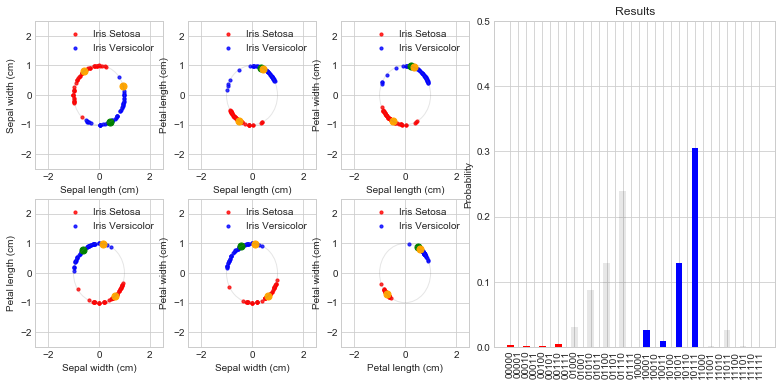

In [13]:
# Get 2 random data points with 4 features.
data_label0, data_label1, x_tilde, random_label = DataPlotter.grab_random_data(size=2, features=4)

#Initialize quantum register:
q = QuantumRegister(6)
meas = measurement(q)

# Initialize circuit:
circuit = four_features_classifier(q, x_tilde, data_label0[0], data_label1[0])
qc = circuit + meas

# Execute the circuit:
probabilities = execute_circuit(qc)

# Display the results:
histogram_results = create_histogram_results(probabilities, number_of_bits=6)


def strip_ancillary_qubit(histogram_results):
    new_histogram_results = {}
    for k, v in histogram_results.items():
        new_histogram_results[k[:-1]] = v  # Strip ancillary qubit
    return new_histogram_results


histogram_results = strip_ancillary_qubit(histogram_results)


def summarize_results_4_features(histogram_results):
    sum_label0 = 0
    sum_label1 = 0
    for key, value in histogram_results.items():
        if key[1] == "0":
            if key[-1] == "0":
                sum_label0 += value
            else:
                sum_label1 += value
    print("Sum Iris Setosa (red, label 0): ", sum_label0)
    print("Sum Iris Versicolor (blue, label 1): ", sum_label1)


summarize_results_4_features(histogram_results)
print("Random label is: ", random_label)
print("Prediction by true classifier: ", DataPlotter.true_classifier(data_label0, data_label1, x_tilde))
    
# Plot results:
DataPlotter.plot_data_points_multiple_features(
    data_label0, data_label1, x_tilde, random_label, histogram_results) # Plot features + bar plot results

In the case of an infinite amount of shots the quantum inspire gives as a result the true probability distribution which coincides with the classical solution of the distance-based classifier. The following table shows the quality of the distance-based classifier depending on the amount of data points and included features. The table contains the percentage of correct predictions for random selected data from the iris set, the results are over a sample of 10.000 runs and can be reproduced using the quality_classifier method of DataPlotter class.

| % correct prediction | 2 features | 3 features | 4 features |
|----------------------|------------|------------|------------|
| 2 data points        | 0.9426     | 0.9870     | 0.9940      |
| 4 data points        | 0.9735     | 0.9933     | 0.9986     |
| 8 data points        | 0.9803     | 0.9975     | 0.9998     |


These results show why one is not only interested in extending the amount of data points but also in including more features for data.

<a name="conclusion"></a>
# Conclusion and further work #

In this notebook we demonstrated how to extended the distance-based classifier to be able to handle data containing up to four features. We saw that the quality of the distance-based classifier improves both by including more data points but also by including data which containing more features.

So far in this notebook series we have only looked at binary classification, the results belong either to the class with a label 0 or to the class with the label 1. For some problems one is interessted in identifying between more than two classes, for example number recognition. A possible next extention for the current classifier is to extend it to being able to classify between more than two labels. This can be done by encoding the label in multiple qubits instead of one qubit.

We have only tested the distance-based classifier on rescaled data from the iris data set, this data set is well classified by the the distance-based classifier. For other data sets this might not necessary be the case. Suppose a different data set which after scaling has different the classes lie in concentric circles, at first glance we do not expect the distance-based classifier to yield good predictions. These problems can possibly be solved by an alternative data pre-processing or by a totally different type of classifier. The task of selecting the right methods for data preprocessing and the corresponding classifier is not a task for the quantum computer but for the data analyst. It will be interessting to see different classifiers implemented on quantum computers in the near future.

[Back to Table of Contents](#contents)

### References ###
* Book: [Schuld and Petruccione, Supervised learning with Quantum computers, 2018](https://www.springer.com/us/book/9783319964232)  
* Article: [Schuld, Fingerhuth and Petruccione, Implementing a distance-based classifier with a quantum interference circuit, 2017](https://arxiv.org/abs/1703.10793)
* Article: [Long & Sun: Efficient scheme for initializing a quantum register with an arbitrary superposed state, 2001](https://arxiv.org/abs/quant-ph/0104030)
* Post: [Build an arbitrary (n)-controlled quantum gate](https://physics.stackexchange.com/questions/142470/realisation-of-arbitrary-controlled-quantum-gate)